In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load Dataset
url = "https://raw.githubusercontent.com/Rohanrathod7/my-ds-projects/main/05_eda_categorical/customer_segmentation/Data/Mall_Customers.csv"

df = pd.read_csv(url)
print(df.info(), '\n', df.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None 
    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [37]:
# Nominal vs Ordinal identification
print("Gender value counts:\n", df['Gender'].value_counts())

# Creating new categorical columns
df['IncomeBracket'] = pd.cut(df['Annual Income (k$)'],
    bins=[0,40,70,150], labels=['Low','Medium','High'])
df['AgeGroup'] = pd.cut(df['Age'], bins=[0,25,40,100], labels=['<25','25-40','40+'])

# value_counts() and groupby()
print(df['IncomeBracket'].value_counts())
print(df.groupby('Gender')['Spending Score (1-100)'].mean())



Gender value counts:
 Gender
Female    112
Male       88
Name: count, dtype: int64
IncomeBracket
Medium    76
High      74
Low       50
Name: count, dtype: int64
Gender
Female    51.526786
Male      48.511364
Name: Spending Score (1-100), dtype: float64


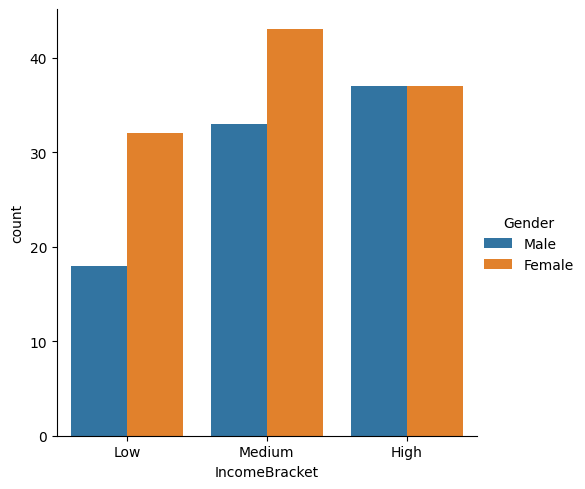

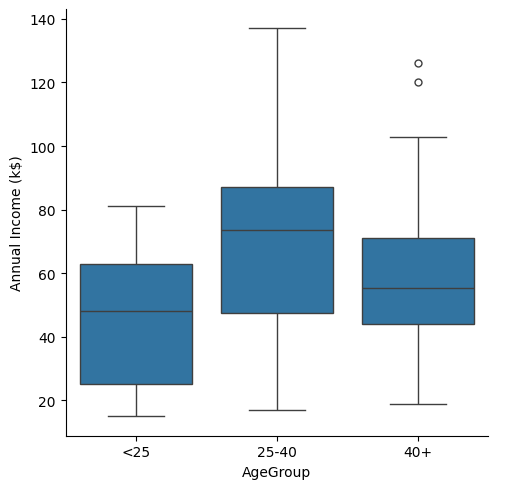

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),AgeGroup,SpendCat,GenderEncoded,Income_Low,Income_Medium,Income_High
0,1,Male,19,15,39,<25,Medium,1,True,False,False
1,2,Male,21,15,81,<25,Very High,1,True,False,False
2,3,Female,20,16,6,<25,Low,0,True,False,False
3,4,Female,23,16,77,<25,Very High,0,True,False,False
4,5,Female,31,17,40,25-40,Medium,0,True,False,False


In [38]:
# Setting ordered categorical
spend_order = [1,25,50,75,100]
df['SpendCat'] = pd.cut(df['Spending Score (1-100)'],
    bins=[0,25,50,75,100], labels=['Low','Medium','High','Very High'], ordered=True)

# Drop original Income
df2 = df.drop(columns=['CustomerID'])

# Visualization
sns.catplot(x='IncomeBracket', hue='Gender', kind='count', data=df2)
plt.show()
sns.catplot(x='AgeGroup', y='Annual Income (k$)', kind='box', data=df2)
plt.show()

# Label encoding Gender
le = LabelEncoder()
df['GenderEncoded'] = le.fit_transform(df['Gender'])

# One-hot encode IncomeBracket
df = pd.get_dummies(df, columns=['IncomeBracket'], prefix='Income')

df.head()

In [39]:
df['CLV'] = df['Annual Income (k$)'] * df['Spending Score (1-100)']
df['CLV_Category'] = pd.qcut(df['CLV'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])


IncomeBracket       Low    Medium      High
Gender                                     
Female         0.285714  0.383929  0.330357
Male           0.204545  0.375000  0.420455


<Axes: title={'center': 'Income Bracket by Gender'}, xlabel='Gender'>

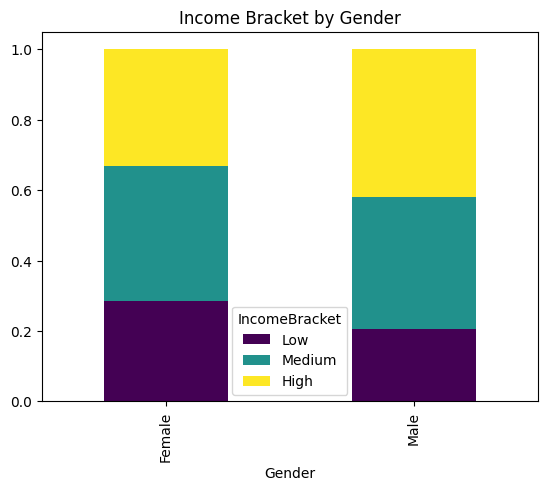

In [40]:
# Recreate IncomeBracket for this plot as it was removed during one-hot encoding
df['IncomeBracket'] = pd.cut(df['Annual Income (k$)'],
    bins=[0,40,70,150], labels=['Low','Medium','High'])

ct = pd.crosstab(df['Gender'], df['IncomeBracket'], normalize='index')
print(ct)
ct.plot(kind='bar', stacked=True, colormap='viridis', title='Income Bracket by Gender')

**Hypothesis Generation**  
Hypothesis: "Males in the high-income group tend to have lower spending scores than females in the same bracket."

<Axes: xlabel='Gender', ylabel='Spending Score (1-100)'>

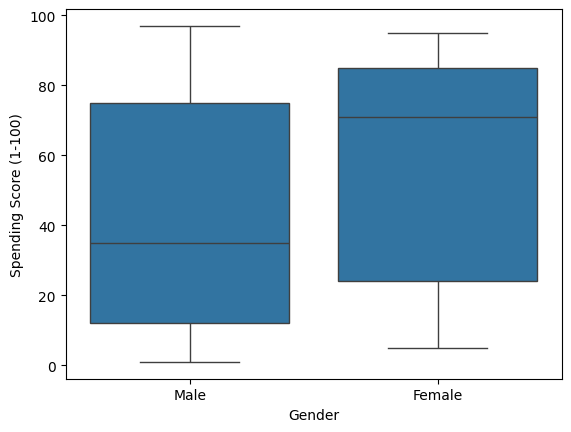

In [41]:
high_income = df[df['IncomeBracket'] == 'High']
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=high_income)


**Spending Behavior Clustering Preparation**  
Prepare data for future clustering based on selected encoded features.

In [42]:
features = df[['GenderEncoded', 'Annual Income (k$)', 'Spending Score (1-100)']]
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(features)


**Geographic Segmentation (synthetic)**

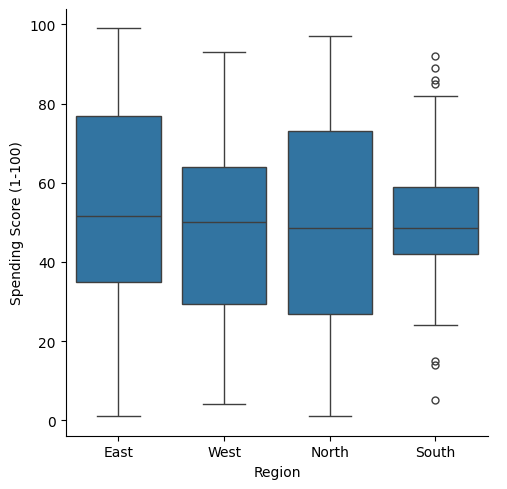

In [43]:
np.random.seed(42)
regions = ['North', 'South', 'East', 'West']
df['Region'] = np.random.choice(regions, size=len(df))
sns.catplot(x='Region', y='Spending Score (1-100)', kind='box', data=df)


**Detect Inconsistencies in Categorical Data**  
Example: correcting miscapitalized entries (synthetic case).

In [44]:
df['Gender'] = df['Gender'].str.capitalize().replace({'FeMale': 'Female'})


**Encoding Ordinal Category as Scores**  

In [45]:
ordinal_map = {'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
df['SpendCat_Score'] = df['SpendCat'].map(ordinal_map)


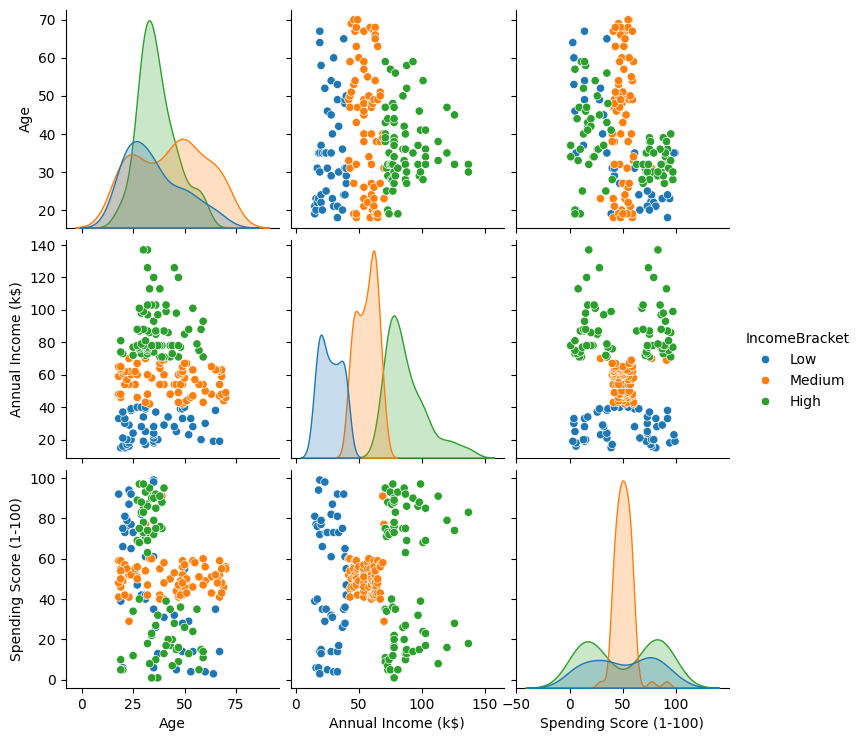

In [46]:
# Create a temporary DataFrame with the original IncomeBracket column for pairplot
temp_df_for_pairplot = df.copy()

# Ensure IncomeBracket is in the temporary DataFrame (it might have been dropped by one-hot encoding in df)
temp_df_for_pairplot['IncomeBracket'] = pd.cut(temp_df_for_pairplot['Annual Income (k$)'],
    bins=[0,40,70,150], labels=['Low','Medium','High'])

# Explicitly select the columns for the pairplot
pairplot_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'IncomeBracket']
temp_df_for_pairplot = temp_df_for_pairplot[pairplot_cols]

sns.pairplot(temp_df_for_pairplot, hue='IncomeBracket', vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'])
plt.show()